In [30]:
import requests
import pandas as pd
import numpy as np
import time
import scipy.stats as stats
import seaborn as sns
sns.set()

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

from sklearn.preprocessing import FunctionTransformer, StandardScaler 
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn_pandas import DataFrameMapper

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]

In [31]:
GP_df = pd.read_csv('../Data/final_Data_for_Modeling.csv', parse_dates=['Date'])
GP_df

,Unnamed: 0,Date,Gold,Silver,Platinum,Palladium,SP500,DJI,FTSE,TBill,FedFundRates,USDX,GoldFutures,OilSpot
0,0,2000-01-04,282.05,5.3025,442.0,444.0,1399.420044,10997.929688,6665.86,6.49,5.38,100.100,282.7,25.56
1,1,2000-01-05,282.10,5.2850,438.0,438.0,1402.109985,11122.650391,6535.90,6.62,5.41,100.050,281.1,24.65
2,2,2000-01-06,280.35,5.1400,420.0,435.0,1403.449951,11253.259766,6447.24,6.57,5.54,100.340,281.4,24.79
3,3,2000-01-07,282.10,5.1350,418.0,438.0,1441.469971,11522.559570,6504.75,6.52,5.61,100.500,281.9,24.79
4,4,2000-01-10,281.70,5.1450,418.0,449.0,1457.599976,11572.200195,6607.71,6.57,5.74,100.650,281.7,24.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4858,4972,2019-09-26,1507.05,17.9700,932.0,1663.0,2977.620117,26891.119141,7351.08,1.70,1.85,98.765,1511.6,56.24
4859,4973,2019-09-27,1496.15,17.5200,929.0,1670.0,2961.790039,26820.250000,7426.21,1.69,1.83,98.761,1511.6,55.95
4860,4974,2019-09-30,1487.60,17.2550,925.0,1691.0,2976.739990,26916.830078,7408.21,1.68,1.90,99.021,1511.6,54.09
4861,4975,2019-10-01,1473.45,17.1100,881.0,1667.0,2940.250000,26573.039063,7408.21,1.68,1.90,98.777,1511.6,54.09


In [32]:
GP_df['Gold_next'] = GP_df['Gold'].shift(periods=-1)
GP_df['Gold_1week'] = GP_df['Gold'].shift(periods=-5)
GP_df['Gold_4week'] = GP_df['Gold'].shift(periods=-28)
GP_df['Gold_prev'] = GP_df['Gold'].shift(periods=1)
# Gold percentge change (todays over previous close)
GP_df['Gold_chg'] = 100*(GP_df['Gold'] - GP_df['Gold_prev'])/GP_df['Gold_prev']
#
GP_df['GPInc'] = (GP_df['Gold_next']/GP_df['Gold']-1)
GP_df["year"]=pd.to_datetime(GP_df['Date'], format='%Y-%m-%d').dt.year - 2000
GP_df

,Unnamed: 0,Date,Gold,Silver,Platinum,Palladium,SP500,DJI,FTSE,TBill,...,USDX,GoldFutures,OilSpot,Gold_next,Gold_1week,Gold_4week,Gold_prev,Gold_chg,GPInc,year
0,0,2000-01-04,282.05,5.3025,442.0,444.0,1399.420044,10997.929688,6665.86,6.49,...,100.100,282.7,25.56,282.10,282.25,308.75,NaN,NaN,0.000177,0
1,1,2000-01-05,282.10,5.2850,438.0,438.0,1402.109985,11122.650391,6535.90,6.62,...,100.050,281.1,24.65,280.35,282.25,307.00,282.05,0.017727,-0.006203,0
2,2,2000-01-06,280.35,5.1400,420.0,435.0,1403.449951,11253.259766,6447.24,6.57,...,100.340,281.4,24.79,282.10,282.20,302.50,282.10,-0.620347,0.006242,0
3,3,2000-01-07,282.10,5.1350,418.0,438.0,1441.469971,11522.559570,6504.75,6.52,...,100.500,281.9,24.79,281.70,284.15,306.25,280.35,0.624220,-0.001418,0
4,4,2000-01-10,281.70,5.1450,418.0,449.0,1457.599976,11572.200195,6607.71,6.57,...,100.650,281.7,24.71,282.25,286.85,303.55,282.10,-0.141794,0.001952,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4858,4972,2019-09-26,1507.05,17.9700,932.0,1663.0,2977.620117,26891.119141,7351.08,1.70,...,98.765,1511.6,56.24,1496.15,NaN,NaN,1530.85,-1.554692,-0.007233,19
4859,4973,2019-09-27,1496.15,17.5200,929.0,1670.0,2961.790039,26820.250000,7426.21,1.69,...,98.761,1511.6,55.95,1487.60,NaN,NaN,1507.05,-0.723267,-0.005715,19
4860,4974,2019-09-30,1487.60,17.2550,925.0,1691.0,2976.739990,26916.830078,7408.21,1.68,...,99.021,1511.6,54.09,1473.45,NaN,NaN,1496.15,-0.571467,-0.009512,19
4861,4975,2019-10-01,1473.45,17.1100,881.0,1667.0,2940.250000,26573.039063,7408.21,1.68,...,98.777,1511.6,54.09,1492.60,NaN,NaN,1487.60,-0.951197,0.012997,19


In [36]:
train_set_def = GP_df['year']<=15
test_set_def = (GP_df['year']>15) * (GP_df['year']<=18)
small_test_def = (GP_df['year']>15) * (GP_df['year']<=16)

In [140]:
def linear_wCoefs(xt, yt, xval, yval):
    lm = LinearRegression(fit_intercept=True)

    lm.fit(xt, yt)
    # score fit model on validation data
    val_score = lm.score(xval, yval)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    if lm.fit_intercept:
        print("Intercept : {:.8f}".format(lm.intercept_))
    
    for feature, coef in zip(xt.columns, lm.coef_):
        print(feature, ':', f'{coef:.8f}')
    
    pred = lm.predict(xval)
    
    xvar1 = xt.columns[0]
    #yvar = yt.columns[0]
    
    plt.subplot(1, 3, 1)
    plt.scatter(xval[xvar1],yval)
    #plt.plot(xval['Gold'], pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel(xvar1)
    plt.ylabel('y')
    
    plt.subplot(1, 3, 2)
    res = yval - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [38]:
def return_GoldDF(xvars, yvars, trainSet, testSet):
    """
    """
    x_train = GP_df.loc[trainSet, xvars].dropna(axis=0).copy()
    y_train = GP_df.loc[trainSet, xvars + [yvars]].dropna(axis=0)[yvars].copy()

    x_test = GP_df.loc[testSet, xvars].dropna(axis=0).copy()
    y_test = GP_df.loc[testSet, xvars + [yvars]].dropna(axis=0)[yvars].copy()
    
    return x_train, x_test, y_train, y_test


Validation R^2 score was: 0.9714574364550326
Feature coefficient results: 

Intercept : 10.39137352
Gold : 0.85034073
GoldFutures : 0.13848342
Silver : 0.59075350
Platinum : 0.00656726
Palladium : -0.01185987
OilSpot : -0.11570374
DJI : -0.00187007
FTSE : 0.00374421
TBill : -2.79818007
FedFundRates : 0.67760271
USDX : 0.05662515


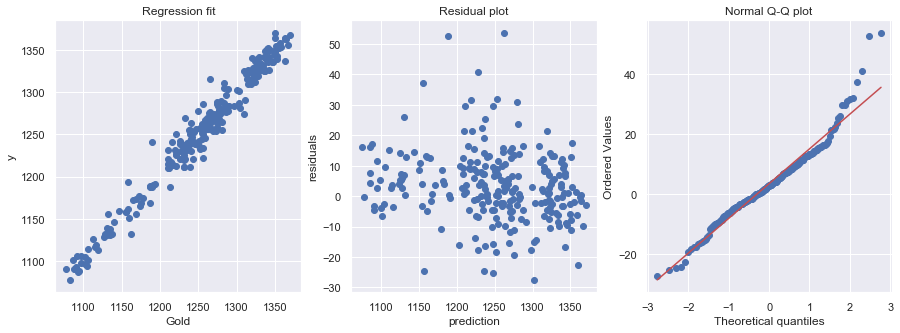

In [41]:
x_vars2 = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
             'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX']
y_var2 = 'Gold_next'

x_train2, x_test2, y_train2, y_test2 = return_GoldDF(x_vars2, y_var2, train_set_def, small_test_def)

linear_wCoefs(x_train2, y_train2, x_test2, y_test2)

In [42]:
fit2 = sm.OLS(y_train2, x_train2).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Gold_next   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.451e+06
Date:                Tue, 08 Oct 2019   Prob (F-statistic):                        0.00
Time:                        18:24:32   Log-Likelihood:                         -15277.
No. Observations:                3934   AIC:                                  3.058e+04
Df Residuals:                    3923   BIC:                                  3.065e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold             0.8509      0.009     95.048      0.000       0.833       0.868
GoldFutures      0.1397      0.008     16.502      0.000       0.123       0.156
Silver           0.5758      0.092      6.280      0.000       0.396       0.756
Platinum         0.0079      0.002      5.122      0.000       0.005       0.011
Palladium       -0.0141      0.002     -8.442      0.000      -0.017      -0.011
OilSpot         -0.1112      0.020     -5.466      0.000      -0.151      -0.071
DJI             -0.0017      0.000     -6.885      0.000      -0.002      -0.001
FTSE             0.0035      0.001      3.420      0.001       0.001       0.005
TBill           -2.3405      0.542     -4.322      0.000      -3.402      -1.279
FedFundRates     0.6980      0.258      2.703      0.007       0.192       1.204
USDX             0.1293      0.022      5.783      0.000       0.085       0.173
==============================================================================
Omnibus:                     1397.931   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           544887.684
Skew:                          -0.185   Prob(JB):                         0.00
Kurtosis:                      60.654   Cond. No.                     3.91e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Naive solution R2: 0.97152412
Prediction solution R2: 0.97192878


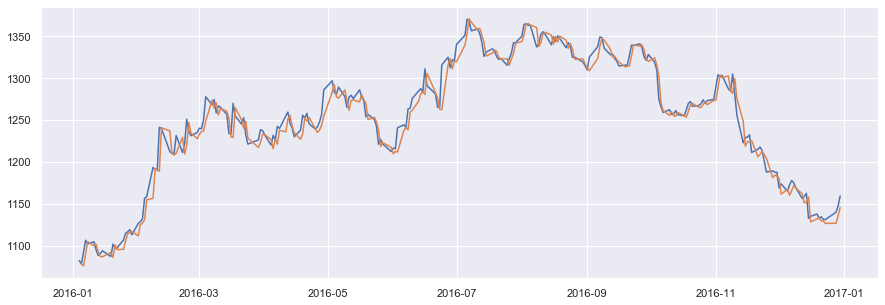

In [176]:
ypred2 = fit2.predict(x_test2)

plt.rcParams['figure.figsize'] = [15, 5]
naive_r2 = r2_score(GP_df.loc[small_test_def, 'Gold_next'], GP_df.loc[small_test_def, 'Gold'])
print("Naive solution R2: {:.8f}".format(naive_r2))
pred_r2 = r2_score(GP_df.loc[small_test_def, 'Gold_next'], ypred2)
print("Prediction solution R2: {:.8f}".format(pred_r2))

# Gold price - Blue line
plt.plot(GP_df.loc[small_test_def, 'Date'], GP_df.loc[small_test_def, 'Gold']);

# Gold price prediction - Orange line
plt.plot(GP_df.loc[small_test_def, 'Date'], pd.Series(ypred2).shift(periods=1));

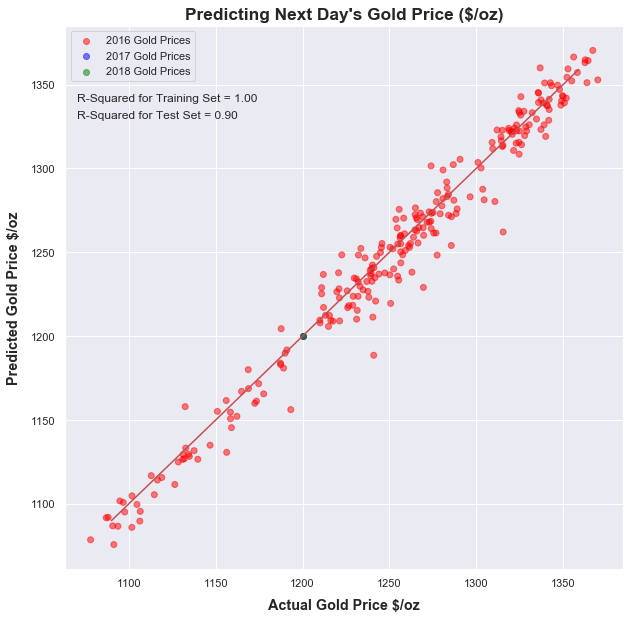

In [46]:
# Model #2
colors = {16:'red', 17:'blue', 18:'green'}
cols = GP_df.loc[small_test_def, 'year'].apply(lambda x: colors[x])


plt.rcParams['figure.figsize'] = [10, 10]
ypred2 = pd.Series(fit2.predict(x_test2))
plt.scatter(y_test2, ypred2, c = cols, alpha=0.5);

for i in range(16,19):
    plt.scatter(1200, 1200, c = colors[i], alpha=0.5, label = "20{} Gold Prices".format(i));


x_fit_line=[x for x in range(1090, 1360)]
plt.plot(x_fit_line, x_fit_line, c="r",)
plt.xlabel("Actual Gold Price $/oz", fontweight='bold', fontsize = 'x-large', labelpad=10)
plt.ylabel("Predicted Gold Price $/oz", fontweight='bold', fontsize = 'x-large', labelpad=10)
plt.title("Predicting Next Day's Gold Price ($/oz)", fontweight='bold', fontsize = 'xx-large')
plt.text(1070, 1340, "R-Squared for Training Set = 1.00", fontsize=12)
plt.text(1070, 1330, "R-Squared for Test Set = 0.90", fontsize=12)
plt.legend()

## Models with scaled features
### Implementation using 'piplelines' (checked against native implementation)

In [167]:
prices_log = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
             'DJI', 'FTSE']
rates = ['TBill', 'FedFundRates', 'USDX']

posTransform = make_pipeline(FunctionTransformer(np.log), StandardScaler())
mapper = DataFrameMapper([
    (prices_log, posTransform),
    (rates, StandardScaler())
])

mapper.fit_transform(x_train2)
pipe = make_pipeline(mapper, LinearRegression())

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [168]:
logy_train2 = pd.Series(np.log(y_train2))
logy_mean = logy_train2.mean()
logy_std = logy_train2.std()
logy_train2 = (logy_train2 - logy_mean)/logy_std

pipe.fit(x_train2, logy_train2)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('dataframemapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['Gold', 'GoldFutures', 'Silver',
                                             'Platinum', 'Palladium', 'OilSpot',
                                             'DJI', 'FTSE'],
                                            Pipeline(memory=None,
                                                     steps=[('functiontransformer',
                                                             FunctionTransformer(accept_sparse=False,
                                                                                 check_inverse=True,
                                                                                 func=<ufunc 'log'>,
                                                                                 inv_kw_args=None,
                                                                                 inverse_func=None,
       

In [169]:
yhat = pipe.predict(x_test2)

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


In [170]:
#logy_test2 = pd.Series(np.log(y_test2))
#print(r2_score(logy_test2, yhat))
pipe.named_steps['dataframemapper']
print(type(df_step1))    
dfmap = pipe.named_steps['linearregression'].coef_
print("intercept: {:.8f}".format(pipe.named_steps['linearregression'].intercept_))
for feature, coef in zip(prices_log+rates, dfmap):
        print(feature, ':', f'{coef:.8f}')

<class 'sklearn_pandas.dataframe_mapper.DataFrameMapper'>
intercept: 0.00000000
Gold : 0.73764495
GoldFutures : 0.24832738
Silver : 0.02130302
Platinum : 0.00619304
Palladium : -0.00619758
OilSpot : -0.00653136
DJI : -0.00933579
FTSE : 0.00478056
TBill : -0.00492390
FedFundRates : 0.00304236
USDX : 0.00338528


//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Naive solution R2: 0.97152412
Prediction solution R2: 0.97067087


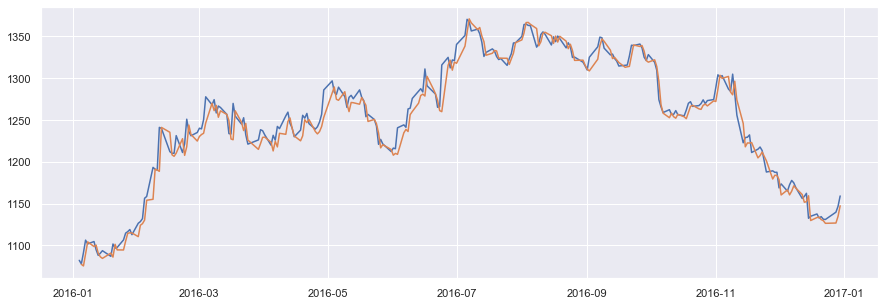

In [177]:
yhat = pipe.predict(x_test2)
gold_yhat = np.exp(yhat*logy_std+logy_mean)

plt.rcParams['figure.figsize'] = [15, 5]
naive_r2 = r2_score(GP_df.loc[small_test_def, 'Gold_next'], GP_df.loc[small_test_def, 'Gold'])
print("Naive solution R2: {:.8f}".format(naive_r2))
pred_r2 = r2_score(GP_df.loc[small_test_def, 'Gold_next'], gold_yhat)
print("Prediction solution R2: {:.8f}".format(pred_r2))

# Next day without Gold chg
plt.plot(GP_df.loc[small_test_def, 'Date'], GP_df.loc[small_test_def, 'Gold']);
# Next day gold predictions
plt.plot(GP_df.loc[small_test_def, 'Date'], pd.Series(gold_yhat).shift(periods=1));

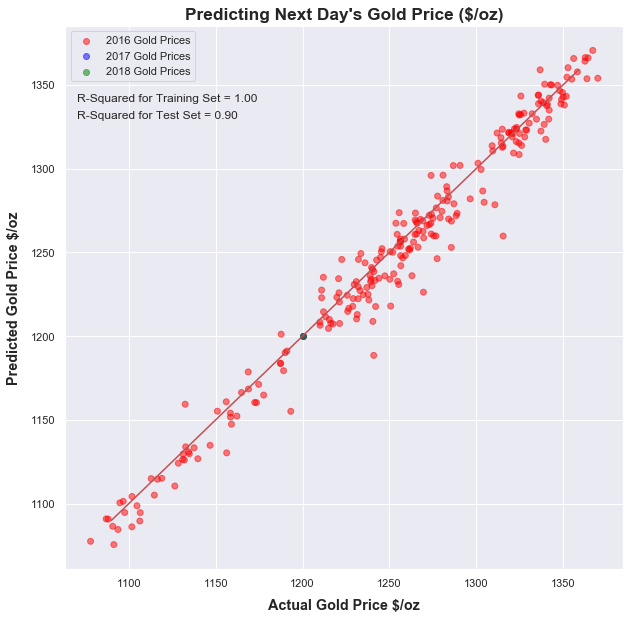

In [173]:
# Model #2
colors = {16:'red', 17:'blue', 18:'green'}
cols = GP_df.loc[small_test_def, 'year'].apply(lambda x: colors[x])


plt.rcParams['figure.figsize'] = [10, 10]
ypred_log = pd.Series(gold_yhat)
plt.scatter(y_test2, ypred_log, c = cols, alpha=0.5);

for i in range(16,19):
    plt.scatter(1200, 1200, c = colors[i], alpha=0.5, label = "20{} Gold Prices".format(i));


x_fit_line=[x for x in range(1090, 1360)]
plt.plot(x_fit_line, x_fit_line, c="r",)
plt.xlabel("Actual Gold Price $/oz", fontweight='bold', fontsize = 'x-large', labelpad=10)
plt.ylabel("Predicted Gold Price $/oz", fontweight='bold', fontsize = 'x-large', labelpad=10)
plt.title("Predicting Next Day's Gold Price ($/oz)", fontweight='bold', fontsize = 'xx-large')
plt.text(1070, 1340, "R-Squared for Training Set = 1.00", fontsize=12)
plt.text(1070, 1330, "R-Squared for Test Set = 0.90", fontsize=12)
plt.legend()

In [160]:
# --- To check that the above implementation using the DataFrameMapper is done correctly

x_vars2 = ['Gold', 'GoldFutures','Silver', 'Platinum', 'Palladium', 'OilSpot', \
             'DJI', 'FTSE', 'TBill', 'FedFundRates', 'USDX']
y_var2 = 'Gold_next'

x_train2check, x_test2check, y_train2check, y_test2check = return_GoldDF(x_vars2, y_var2, train_set_def, small_test_def)
x_train2check.loc[:,prices_log] = x_train2check.transform(lambda x: np.log(x))
x_test2check.loc[:,prices_log] = x_test2check.transform(lambda x: np.log(x))

transform = {}

for i in x_train2check.columns:
    mean = x_train2check.loc[:,i].mean()
    std = x_train2check.loc[:,i].std()
    transform[i] = [mean, std]
    x_train2check.loc[:,i] = (x_train2check.loc[:,i]-mean)/std
print(transform)

for i in x_test2check.columns:
    mean = transform[i][0]
    std = transform[i][1]
    x_test2check.loc[:,i] = (x_test2check.loc[:,i]-mean)/std

{'Gold': [6.560769347225535, 0.6312102629995561], 'GoldFutures': [6.569389638745999, 0.641426378738715], 'Silver': [2.457111527454012, 0.6815417123688791], 'Platinum': [6.952873974451973, 0.41824583702017554], 'Palladium': [6.052905815062155, 0.5142111174192853], 'OilSpot': [4.0420037875256005, 0.49979054380882704], 'DJI': [9.35792648069556, 0.21309574753984165], 'FTSE': [8.613245158903768, 0.16463314512545954], 'TBill': [3.708612099644128, 1.211285207567448], 'FedFundRates': [1.8967208947635994, 2.102253310214003], 'USDX': [89.37596720894764, 12.591527211769497]}


In [161]:
y_train2check = y_train2check.transform(lambda x: np.log(x))
y_test2check = y_test2check.transform(lambda x: np.log(x))
y_mean = y_train2check.mean()
y_std = y_train2check.std()

In [162]:
y_train2check = (y_train2check - y_mean)/y_std
y_test2check = (y_test2check - y_mean)/y_std
y_train2check

0      -1.456003
1      -1.465864
2      -1.456003
3      -1.458251
4      -1.455161
          ...   
3929    0.659313
3930    0.656649
3931    0.653240
3932    0.644982
3933    0.674540
Name: Gold_next, Length: 3934, dtype: float64

In [163]:
plt.rcParams['figure.figsize'] = [15, 5]
lm = LinearRegression()
lm.fit(x_train2check, y_train2check)
val_score = lm.score(x_test2check, y_test2check)
    
# report results
print('\nValidation R^2 score was:', val_score)
print('Feature coefficient results: \n')
if lm.fit_intercept:
    print("Intercept : {:.8f}".format(lm.intercept_))
    
for feature, coef in zip(x_train2check.columns, lm.coef_):
    print(feature, ':', f'{coef:.8f}')
    
pred = lm.predict(x_test2check)


Validation R^2 score was: 0.9712874409227547
Feature coefficient results: 

Intercept : 0.00000000
Gold : 0.73773872
GoldFutures : 0.24835895
Silver : 0.02130573
Platinum : 0.00619383
Palladium : -0.00619837
OilSpot : -0.00653219
DJI : -0.00933698
FTSE : 0.00478117
TBill : -0.00492453
FedFundRates : 0.00304275
USDX : 0.00338572


In [164]:
fit2check = sm.OLS(y_train2check, x_train2check).fit()
fit2check.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Gold_next   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          9.497e+05
Date:                Wed, 09 Oct 2019   Prob (F-statistic):                        0.00
Time:                        05:44:52   Log-Likelihood:                          9933.2
No. Observations:                3934   AIC:                                 -1.984e+04
Df Residuals:                    3923   BIC:                                 -1.978e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold             0.7377      0.011     64.446      0.000       0.715       0.760
GoldFutures      0.2484      0.011     23.032      0.000       0.227       0.269
Silver           0.0213      0.002      8.770      0.000       0.017       0.026
Platinum         0.0062      0.001      4.234      0.000       0.003       0.009
Palladium       -0.0062      0.001     -7.588      0.000      -0.008      -0.005
OilSpot         -0.0065      0.001     -5.661      0.000      -0.009      -0.004
DJI             -0.0093      0.001     -8.757      0.000      -0.011      -0.007
FTSE             0.0048      0.001      3.403      0.001       0.002       0.008
TBill           -0.0049      0.001     -4.693      0.000      -0.007      -0.003
FedFundRates     0.0030      0.001      3.582      0.000       0.001       0.005
USDX             0.0034      0.001      2.715      0.007       0.001       0.006
==============================================================================
Omnibus:                     2815.474   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2932247.143
Skew:                           1.999   Prob(JB):                         0.00
Kurtosis:                     136.689   Cond. No.                         136.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [178]:
yhat2_check = np.exp((pred * y_std) + y_mean)
print("Mean: {:.8f}, Std: {:.8f}".format(y_mean, y_std))

Mean: 6.56111117, Std: 0.63107673
